# Training Neural Networks with Noisy Labels

Neural networks, especially deep neural networks with many parameters, require a large amount of training data. This has led to the development of sophisticated data augmentation methods as well as entire industries dedicated to data annotation. The validation of these annotation labels is a common problem whenever such a large amount of data is involved as incorrect, or noisy, labels can lead to incorrectly trained machine learning algorithms that do not properly identify patterns within the data.

All code can be found on the Github repository, [Learning with Noisy Labels](https://github.com/DragonDuck/LearningWithNoisyLabels).

## Imports

In [13]:
# Ensure reproducible results
import numpy as np
np.random.seed(101)
import tensorflow 
tensorflow.set_random_seed(101)
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.model_selection
import sklearn.metrics
import keras.utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten

## The Data
To showcase the effects of noisy labels, I will use the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/). I have previously downloaded and pre-processed the data and stored it in an HDF5 file.

In [2]:
with h5py.File("MNIST.h5", "r") as h5handle:
    images = h5handle["images"][()]
    labels = h5handle["labels"][()]

The images are stored as a 4D array (Tensorflow format: batch size, width, height, number of channels) and the labels are a simple 1D array.

In [3]:
print("Images array shape: {}".format(images.shape))
print("Labels array shape: {}".format(labels.shape))

Images array shape: (70000, 28, 28, 1)
Labels array shape: (70000,)


A look at some of the digits shows us the expected output.

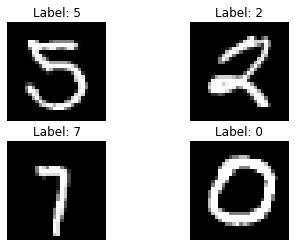

In [4]:
fig, ax = plt.subplots(2, 2);
ax[0, 0].imshow(images[284, ..., 0], cmap="gray");
ax[0, 0].set_title("Label: " + str(labels[284]));
ax[0, 0].axis("off");
ax[0, 1].imshow(images[1129, ..., 0], cmap="gray");
ax[0, 1].set_title("Label: " + str(labels[1129]));
ax[0, 1].axis("off");
ax[1, 0].imshow(images[9470, ..., 0], cmap="gray");
ax[1, 0].set_title("Label: " + str(labels[9470]));
ax[1, 0].axis("off");
ax[1, 1].imshow(images[30044, ..., 0], cmap="gray");
ax[1, 1].set_title("Label: " + str(labels[30044]));
ax[1, 1].axis("off");
plt.show()

I separate the data into a training and a test dataset.

## The Model
I'll be using a simple convolutional network for this task. MNIST is an extremely easy dataset to classify and doesn't require a particularly sophisticated model.

In [5]:
def get_model(img_shape, nclasses):
    """
    Build convolutional network
    :param img_shape:
    :param nclasses:
    :return:
    """
    inputs = Input(shape=img_shape, name="Input")
    conv1 = Conv2D(
        filters=32, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv1")(inputs)
    conv2 = Conv2D(
        filters=32, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv2")(conv1)
    maxpool1 = MaxPool2D(
        pool_size=(3, 3), strides=(2, 2), 
        padding="valid", name="MaxPool1")(conv2)

    conv3 = Conv2D(
        filters=64, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv3")(maxpool1)
    conv4 = Conv2D(
        filters=64, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv4")(conv3)
    maxpool2 = MaxPool2D(
        pool_size=(3, 3), strides=(2, 2), 
        padding="valid", name="MaxPool2")(conv4)

    flattened = Flatten(name="Reshape")(maxpool2)

    outputs = Dense(name="Dense", units=nclasses, activation="sigmoid")(flattened)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="Adam")
    
    return model

In [6]:
model = get_model(
    img_shape=images.shape[1:4], 
    nclasses=len(np.unique(labels)))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
def print_model(model):
    desc = "Name      | Output Shape        | Kernel / Pool Shape\n"
    desc += "----------|---------------------|--------------------\n"
    for layer in model.layers:
        desc += "{:<10}|".format(layer.name)
        desc += " {:<20}|".format(str(layer.output_shape))
        if hasattr(layer, "kernel"):
            desc += " {:<20}".format(str(layer.kernel.shape.as_list()))
        if hasattr(layer, "pool_size"):
            desc += " {:<20}".format(str(layer.pool_size))
        desc += "\n"
    print(desc)
    
print_model(model)

Name      | Output Shape        | Kernel / Pool Shape
----------|---------------------|--------------------
Input     | (None, 28, 28, 1)   |
Conv1     | (None, 26, 26, 32)  | [3, 3, 1, 32]       
Conv2     | (None, 24, 24, 32)  | [3, 3, 32, 32]      
MaxPool1  | (None, 11, 11, 32)  | (3, 3)              
Conv3     | (None, 9, 9, 64)    | [3, 3, 32, 64]      
Conv4     | (None, 7, 7, 64)    | [3, 3, 64, 64]      
MaxPool2  | (None, 3, 3, 64)    | (3, 3)              
Reshape   | (None, 576)         |
Dense     | (None, 10)          | [576, 10]           



## Scrambling the labels
Next, I want to define a function that scrambles the labels. It's important that this function allows us to control the fraction of labels that are guaranteed to be correct. That means labels selected for scrambling may not get their original label assigned to them.

In [8]:
def scramble_labels(labels, percentage, possible_values=None):
    """
    Takes a label vector and randomly scrambles a fraction of the labels.

    The scrambling ensures that none of the altered labels will have their
    original value, i.e. the scrambling percentage is guaranteed.

    By default, the function assumes that 'labels' contains all possible 
    label values. Should this not be the case, 'possible_values' can be used
    to pass a list of all possible labels.

    :param labels: Numpy array (num_labels,)
    :param percentage: Integer
    :param possible_values: Numpy array (num_unique_labels,)
    :return:
    """
    if percentage > 1:
        print("'scramble_freq' truncated to 1.0")
        percentage = 1.0

    if percentage == 0:
        return labels

    labels = labels.flatten()

    labels_to_scramble = np.random.choice(
        a=range(len(labels)),
        size=int(len(labels) * percentage),
        replace=False)

    # Define possible values for each entry
    if possible_values is None:
        possible_values = np.unique(labels)
    
    if not np.all(np.isin(np.unique(labels), possible_values)):
        raise ValueError(
            "'labels' contains values not found in 'possible_values'")
    
    possible_values = np.repeat(
        a=np.expand_dims(possible_values, 0),
        repeats=labels_to_scramble.shape[0],
        axis=0)
    forbidden_values = np.repeat(
        a=np.expand_dims(labels[labels_to_scramble], 1),
        repeats=len(np.unique(labels)), axis=1)

    sel = possible_values != forbidden_values
    new_possible_values = np.reshape(
        a=possible_values[sel],
        newshape=(possible_values.shape[0], possible_values.shape[1]-1))

    new_values = []
    for vals in new_possible_values:
        new_values.append(np.random.choice(vals))
    new_values = np.array(new_values)
    labels[labels_to_scramble] = new_values

    return labels

I can test this function with a dummy example:

In [9]:
dummy_labels = np.arange(10)
print("Original labels: {}".format(dummy_labels))
print("10% scrambling:  {}".format(scramble_labels(dummy_labels, 0.1)))
print("50% scrambling:  {}".format(scramble_labels(dummy_labels, 0.5)))
print("100% scrambling: {}".format(scramble_labels(dummy_labels, 1)))

Original labels: [0 1 2 3 4 5 6 7 8 9]
10% scrambling:  [0 6 2 3 4 5 6 7 8 9]
50% scrambling:  [0 1 2 3 9 3 8 8 8 0]
100% scrambling: [5 9 7 8 8 2 8 8 0 4]


## Training and evaluating the model on scrambled labels
To assess the model's performance, I train the model on the scrambled labels but then assess its performance with regards to the true labels to ascertain how well it reconstructs the correct relationship between input data and true labels from the noisy training data. A comparison of the training and validation losses shows that the models are not overfitting.

In [10]:
f1scores_real = []
f1scores_scrambled = []
training_histories = []
percentages = np.arange(0, 1.1, 0.1)

for p in percentages:
    scrambled_labels = scramble_labels(
        labels=labels, percentage=p)

    x_train, x_test, y_train, y_test, y_scr_train, y_scr_test = sklearn.model_selection.train_test_split(
        images, 
        keras.utils.to_categorical(labels), 
        keras.utils.to_categorical(scrambled_labels), 
        test_size=10000, random_state=101)

    training_histories.append(model.fit(
        x=x_train, y=y_scr_train,
        validation_split=0.3,
        batch_size=32, epochs=5, verbose=2))

    pred = model.predict(x=x_test)

    f1scores_real.append(
        sklearn.metrics.f1_score(
            y_true=np.argmax(y_test, axis=1),
            y_pred=np.argmax(pred, axis=1),
            average="weighted"))

    f1scores_scrambled.append(
        sklearn.metrics.f1_score(
            y_true=np.argmax(y_scr_test, axis=1),
            y_pred=np.argmax(pred, axis=1),
            average="weighted"))

Instructions for updating:
Use tf.cast instead.
Train on 42000 samples, validate on 18000 samples
Epoch 1/5
 - 39s - loss: 0.1782 - val_loss: 0.0752
Epoch 2/5
 - 36s - loss: 0.0503 - val_loss: 0.0413
Epoch 3/5
 - 38s - loss: 0.0357 - val_loss: 0.0356
Epoch 4/5
 - 38s - loss: 0.0271 - val_loss: 0.0391
Epoch 5/5
 - 39s - loss: 0.0233 - val_loss: 0.0435
Train on 42000 samples, validate on 18000 samples
Epoch 1/5
 - 42s - loss: 0.6430 - val_loss: 0.6335
Epoch 2/5
 - 37s - loss: 0.6004 - val_loss: 0.6208
Epoch 3/5
 - 37s - loss: 0.5794 - val_loss: 0.6246
Epoch 4/5
 - 37s - loss: 0.5636 - val_loss: 0.6216
Epoch 5/5
 - 37s - loss: 0.5456 - val_loss: 0.6312
Train on 42000 samples, validate on 18000 samples
Epoch 1/5
 - 35s - loss: 1.0037 - val_loss: 1.0009
Epoch 2/5
 - 31s - loss: 0.9728 - val_loss: 1.0117
Epoch 3/5
 - 34s - loss: 0.9550 - val_loss: 1.0080
Epoch 4/5
 - 35s - loss: 0.9349 - val_loss: 1.0154
Epoch 5/5
 - 41s - loss: 0.9119 - val_loss: 1.0257
Train on 42000 samples, validate on 1

In [20]:
results = pd.DataFrame(
    data={
        "TrueF1": f1scores_real,
        "ScrambledF1": f1scores_scrambled},
    index=np.round(percentages, 2))
results.index.name = "Percentages"
results.to_csv("F1Scores.csv")

Comparing the F1 scores with regards to the true and the scrambled labels reveals a remarkable characteristic: the model is capable of learning the true relationship between input data and target variables even when up to $80\%$ of the training labels are scrambled! In fact, the model fails to properly learn the relationship between input data and the scrambled labels, as evidenced by the steadily-declining F1 score with regarrds to the scrambled labels.

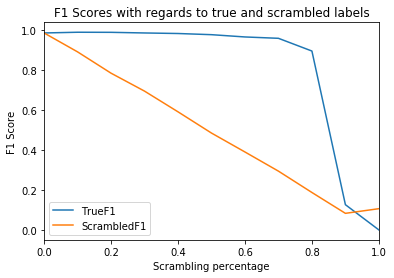

In [28]:
ax = results.plot(title="F1 Scores with regards to true and scrambled labels")
ax.set_xlabel("Scrambling percentage");
ax.set_ylabel("F1 Score");

## Conclusion
A neural network is clearly capable of learning the correct relationship between input data and target variables, even when training labels have been partially falsified. Astonishingly, the true performance doesn't gradually decrease but abruptly fails. In this case, the model performed near-perfectly up to a scrambling percentage of approximately $80\%$. For scrambling percentages above this threshold, the model fails entirely and performance drops to what would be expected of random guessing.

It needs to be said that the MNIST handwritten digits dataset is remarkably simple, which explains the high threshold. More complex datasets will have a lower threshold but should nevertheless elicit the same behaviour in models trained on noisy data.